# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('./input')
feature_dir = Path('./input')
sub_dir = Path('./input')
val_dir = Path('./input')
tst_dir = Path('./input')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 7
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 38)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,tmp1,tmp2,z_i,z_r,z_g,z_u,i_r,i_g,i_u,r_g,r_u,g_u,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ri,d_dered_gi,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_rg,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,1.1898,0.0,-2.9272,-1.3371,-0.7328,-2.0699,-3.3972,-6.3243,-1.3371,-2.6643,-5.5915,-1.3273,-4.2545,-2.9272,2.8665,1.3027,0.7232,1.3230,2.6257,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-1.3027,-4.1691,-2.8665,1.0000
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1.2533,1.0,-0.9902,-0.1840,-0.0995,-0.2835,-0.8930,-1.8832,-0.1840,-0.7935,-1.7837,-0.6096,-1.5997,-0.9902,0.9619,0.5931,0.1016,0.1751,0.7683,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-0.5931,-1.5550,-0.9619,1.0000
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,1.0225,0.0,-0.9610,-0.1428,-0.0435,-0.1863,-0.4754,-1.4364,-0.1428,-0.4319,-1.3928,-0.2891,-1.2501,-0.9610,0.9211,0.2466,0.0257,0.1183,0.3649,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-0.2466,-1.1676,-0.9211,1.0000
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,1.2054,0.0,-4.4719,-0.3262,-0.2603,-0.5865,-1.5541,-6.0260,-0.3262,-1.2938,-5.7657,-0.9676,-5.4395,-4.4719,4.3590,0.9074,0.2395,0.2926,1.2000,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-0.9074,-5.2664,-4.3590,0.7500
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,1.1939,0.0,-3.7543,-0.7182,-0.3415,-1.0597,-2.7165,-6.4708,-0.7182,-2.3750,-6.1293,-1.6568,-5.4111,-3.7543,3.3376,1.5709,0.3144,0.6727,2.2436,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-1.5709,-4.9084,-3.3376,0.9231


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 37) (80000, 37)


## Hyperparameter Tuning

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = {
    "objective": "multiclass",
    "n_estimators": 3000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.4)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100, 150])
}

In [10]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|███████████████████████████████████████████████| 10/10 [02:01<00:00, 12.19s/trial, best loss: 0.15538984455626018]
{'objective': 'multiclass', 'n_estimators': 3000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.015532752528950358, 'min_child_samples': 10, 'num_leaves': 63, 'subsample': 0.7000000000000001}


## Stratified K-Fold Cross Validation

In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.963312
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.942081
[3]	valid_0's multi_logloss: 0.921713
[4]	valid_0's multi_logloss: 0.902258
[5]	valid_0's multi_logloss: 0.882604
[6]	valid_0's multi_logloss: 0.863716
[7]	valid_0's multi_logloss: 0.845491
[8]	valid_0's multi_logloss: 0.828315
[9]	valid_0's multi_logloss: 0.812882
[10]	valid_0's multi_logloss: 0.798268
[11]	valid_0's multi_logloss: 0.781922
[12]	valid_0's multi_logloss: 0.767238
[13]	valid_0's multi_logloss: 0.751952
[14]	valid_0's multi_logloss: 0.7375
[15]	valid_0's multi_logloss: 0.724187
[16]	valid_0's multi_logloss: 0.711921
[17]	valid_0's multi_logloss: 0.698448
[18]	valid_0's multi_logloss: 0.68632
[19]	valid_0's multi_logloss: 0.673899
[20]	valid_0's multi_logloss: 0.661526
[21]	valid_0's multi_logloss: 0.649572
[22]	valid_0's multi_logloss: 0.638242
[23]	valid_0's multi_logloss: 0.628131
[24]	valid_0's multi_logloss:

[210]	valid_0's multi_logloss: 0.177674
[211]	valid_0's multi_logloss: 0.177343
[212]	valid_0's multi_logloss: 0.176978
[213]	valid_0's multi_logloss: 0.176798
[214]	valid_0's multi_logloss: 0.17649
[215]	valid_0's multi_logloss: 0.176255
[216]	valid_0's multi_logloss: 0.175916
[217]	valid_0's multi_logloss: 0.175567
[218]	valid_0's multi_logloss: 0.175267
[219]	valid_0's multi_logloss: 0.175035
[220]	valid_0's multi_logloss: 0.174702
[221]	valid_0's multi_logloss: 0.174537
[222]	valid_0's multi_logloss: 0.174349
[223]	valid_0's multi_logloss: 0.174201
[224]	valid_0's multi_logloss: 0.173994
[225]	valid_0's multi_logloss: 0.173772
[226]	valid_0's multi_logloss: 0.173467
[227]	valid_0's multi_logloss: 0.1733
[228]	valid_0's multi_logloss: 0.173133
[229]	valid_0's multi_logloss: 0.172922
[230]	valid_0's multi_logloss: 0.172679
[231]	valid_0's multi_logloss: 0.172411
[232]	valid_0's multi_logloss: 0.172127
[233]	valid_0's multi_logloss: 0.171901
[234]	valid_0's multi_logloss: 0.171715
[23

[416]	valid_0's multi_logloss: 0.155897
[417]	valid_0's multi_logloss: 0.15586
[418]	valid_0's multi_logloss: 0.155841
[419]	valid_0's multi_logloss: 0.155831
[420]	valid_0's multi_logloss: 0.155801
[421]	valid_0's multi_logloss: 0.155767
[422]	valid_0's multi_logloss: 0.155733
[423]	valid_0's multi_logloss: 0.155693
[424]	valid_0's multi_logloss: 0.155666
[425]	valid_0's multi_logloss: 0.155635
[426]	valid_0's multi_logloss: 0.155613
[427]	valid_0's multi_logloss: 0.155595
[428]	valid_0's multi_logloss: 0.15556
[429]	valid_0's multi_logloss: 0.15554
[430]	valid_0's multi_logloss: 0.155514
[431]	valid_0's multi_logloss: 0.155479
[432]	valid_0's multi_logloss: 0.155461
[433]	valid_0's multi_logloss: 0.155446
[434]	valid_0's multi_logloss: 0.15542
[435]	valid_0's multi_logloss: 0.155405
[436]	valid_0's multi_logloss: 0.155378
[437]	valid_0's multi_logloss: 0.155349
[438]	valid_0's multi_logloss: 0.15531
[439]	valid_0's multi_logloss: 0.1553
[440]	valid_0's multi_logloss: 0.155286
[441]	v

[625]	valid_0's multi_logloss: 0.153193
[626]	valid_0's multi_logloss: 0.153183
[627]	valid_0's multi_logloss: 0.15318
[628]	valid_0's multi_logloss: 0.153177
[629]	valid_0's multi_logloss: 0.153177
[630]	valid_0's multi_logloss: 0.153171
[631]	valid_0's multi_logloss: 0.153164
[632]	valid_0's multi_logloss: 0.15316
[633]	valid_0's multi_logloss: 0.153155
[634]	valid_0's multi_logloss: 0.153148
[635]	valid_0's multi_logloss: 0.153146
[636]	valid_0's multi_logloss: 0.15314
[637]	valid_0's multi_logloss: 0.153131
[638]	valid_0's multi_logloss: 0.153133
[639]	valid_0's multi_logloss: 0.153127
[640]	valid_0's multi_logloss: 0.153126
[641]	valid_0's multi_logloss: 0.153123
[642]	valid_0's multi_logloss: 0.15311
[643]	valid_0's multi_logloss: 0.153101
[644]	valid_0's multi_logloss: 0.153092
[645]	valid_0's multi_logloss: 0.153086
[646]	valid_0's multi_logloss: 0.153076
[647]	valid_0's multi_logloss: 0.153073
[648]	valid_0's multi_logloss: 0.153068
[649]	valid_0's multi_logloss: 0.15307
[650]

[835]	valid_0's multi_logloss: 0.152441
[836]	valid_0's multi_logloss: 0.152442
[837]	valid_0's multi_logloss: 0.152436
[838]	valid_0's multi_logloss: 0.152426
[839]	valid_0's multi_logloss: 0.152428
[840]	valid_0's multi_logloss: 0.152422
[841]	valid_0's multi_logloss: 0.152419
[842]	valid_0's multi_logloss: 0.152415
[843]	valid_0's multi_logloss: 0.152412
[844]	valid_0's multi_logloss: 0.152412
[845]	valid_0's multi_logloss: 0.152408
[846]	valid_0's multi_logloss: 0.152402
[847]	valid_0's multi_logloss: 0.152401
[848]	valid_0's multi_logloss: 0.152399
[849]	valid_0's multi_logloss: 0.1524
[850]	valid_0's multi_logloss: 0.1524
[851]	valid_0's multi_logloss: 0.152396
[852]	valid_0's multi_logloss: 0.152385
[853]	valid_0's multi_logloss: 0.152382
[854]	valid_0's multi_logloss: 0.15237
[855]	valid_0's multi_logloss: 0.152363
[856]	valid_0's multi_logloss: 0.152361
[857]	valid_0's multi_logloss: 0.152364
[858]	valid_0's multi_logloss: 0.152362
[859]	valid_0's multi_logloss: 0.152362
[860]

[55]	valid_0's multi_logloss: 0.406724
[56]	valid_0's multi_logloss: 0.401614
[57]	valid_0's multi_logloss: 0.397703
[58]	valid_0's multi_logloss: 0.393854
[59]	valid_0's multi_logloss: 0.389597
[60]	valid_0's multi_logloss: 0.385727
[61]	valid_0's multi_logloss: 0.381654
[62]	valid_0's multi_logloss: 0.37748
[63]	valid_0's multi_logloss: 0.373587
[64]	valid_0's multi_logloss: 0.369261
[65]	valid_0's multi_logloss: 0.365001
[66]	valid_0's multi_logloss: 0.360858
[67]	valid_0's multi_logloss: 0.357452
[68]	valid_0's multi_logloss: 0.35397
[69]	valid_0's multi_logloss: 0.350422
[70]	valid_0's multi_logloss: 0.347071
[71]	valid_0's multi_logloss: 0.343957
[72]	valid_0's multi_logloss: 0.340459
[73]	valid_0's multi_logloss: 0.336863
[74]	valid_0's multi_logloss: 0.333769
[75]	valid_0's multi_logloss: 0.330337
[76]	valid_0's multi_logloss: 0.3271
[77]	valid_0's multi_logloss: 0.323839
[78]	valid_0's multi_logloss: 0.320755
[79]	valid_0's multi_logloss: 0.31837
[80]	valid_0's multi_logloss: 

[264]	valid_0's multi_logloss: 0.169024
[265]	valid_0's multi_logloss: 0.168872
[266]	valid_0's multi_logloss: 0.168686
[267]	valid_0's multi_logloss: 0.16858
[268]	valid_0's multi_logloss: 0.16841
[269]	valid_0's multi_logloss: 0.168332
[270]	valid_0's multi_logloss: 0.16817
[271]	valid_0's multi_logloss: 0.168071
[272]	valid_0's multi_logloss: 0.167902
[273]	valid_0's multi_logloss: 0.167769
[274]	valid_0's multi_logloss: 0.167639
[275]	valid_0's multi_logloss: 0.16751
[276]	valid_0's multi_logloss: 0.16736
[277]	valid_0's multi_logloss: 0.167226
[278]	valid_0's multi_logloss: 0.167063
[279]	valid_0's multi_logloss: 0.166975
[280]	valid_0's multi_logloss: 0.166885
[281]	valid_0's multi_logloss: 0.166735
[282]	valid_0's multi_logloss: 0.166575
[283]	valid_0's multi_logloss: 0.166462
[284]	valid_0's multi_logloss: 0.166308
[285]	valid_0's multi_logloss: 0.166196
[286]	valid_0's multi_logloss: 0.16608
[287]	valid_0's multi_logloss: 0.165973
[288]	valid_0's multi_logloss: 0.165905
[289]	

[471]	valid_0's multi_logloss: 0.157096
[472]	valid_0's multi_logloss: 0.157083
[473]	valid_0's multi_logloss: 0.157075
[474]	valid_0's multi_logloss: 0.157062
[475]	valid_0's multi_logloss: 0.157046
[476]	valid_0's multi_logloss: 0.157035
[477]	valid_0's multi_logloss: 0.157023
[478]	valid_0's multi_logloss: 0.157009
[479]	valid_0's multi_logloss: 0.156998
[480]	valid_0's multi_logloss: 0.156989
[481]	valid_0's multi_logloss: 0.156977
[482]	valid_0's multi_logloss: 0.156964
[483]	valid_0's multi_logloss: 0.156939
[484]	valid_0's multi_logloss: 0.156926
[485]	valid_0's multi_logloss: 0.156904
[486]	valid_0's multi_logloss: 0.156894
[487]	valid_0's multi_logloss: 0.156877
[488]	valid_0's multi_logloss: 0.156861
[489]	valid_0's multi_logloss: 0.15684
[490]	valid_0's multi_logloss: 0.156817
[491]	valid_0's multi_logloss: 0.156798
[492]	valid_0's multi_logloss: 0.156779
[493]	valid_0's multi_logloss: 0.156761
[494]	valid_0's multi_logloss: 0.156746
[495]	valid_0's multi_logloss: 0.156734
[

[679]	valid_0's multi_logloss: 0.155184
[680]	valid_0's multi_logloss: 0.155179
[681]	valid_0's multi_logloss: 0.155175
[682]	valid_0's multi_logloss: 0.155167
[683]	valid_0's multi_logloss: 0.155158
[684]	valid_0's multi_logloss: 0.155152
[685]	valid_0's multi_logloss: 0.155144
[686]	valid_0's multi_logloss: 0.155132
[687]	valid_0's multi_logloss: 0.155123
[688]	valid_0's multi_logloss: 0.155121
[689]	valid_0's multi_logloss: 0.155119
[690]	valid_0's multi_logloss: 0.155111
[691]	valid_0's multi_logloss: 0.155104
[692]	valid_0's multi_logloss: 0.155099
[693]	valid_0's multi_logloss: 0.155102
[694]	valid_0's multi_logloss: 0.155106
[695]	valid_0's multi_logloss: 0.155104
[696]	valid_0's multi_logloss: 0.155097
[697]	valid_0's multi_logloss: 0.155089
[698]	valid_0's multi_logloss: 0.155084
[699]	valid_0's multi_logloss: 0.155081
[700]	valid_0's multi_logloss: 0.155076
[701]	valid_0's multi_logloss: 0.155076
[702]	valid_0's multi_logloss: 0.155073
[703]	valid_0's multi_logloss: 0.155066


[889]	valid_0's multi_logloss: 0.154607
[890]	valid_0's multi_logloss: 0.154607
[891]	valid_0's multi_logloss: 0.15461
[892]	valid_0's multi_logloss: 0.154616
[893]	valid_0's multi_logloss: 0.154613
[894]	valid_0's multi_logloss: 0.15461
[895]	valid_0's multi_logloss: 0.154608
[896]	valid_0's multi_logloss: 0.154608
[897]	valid_0's multi_logloss: 0.154609
[898]	valid_0's multi_logloss: 0.154605
[899]	valid_0's multi_logloss: 0.154601
[900]	valid_0's multi_logloss: 0.1546
[901]	valid_0's multi_logloss: 0.154606
[902]	valid_0's multi_logloss: 0.154604
[903]	valid_0's multi_logloss: 0.1546
[904]	valid_0's multi_logloss: 0.154599
[905]	valid_0's multi_logloss: 0.154589
[906]	valid_0's multi_logloss: 0.15458
[907]	valid_0's multi_logloss: 0.154579
[908]	valid_0's multi_logloss: 0.154575
[909]	valid_0's multi_logloss: 0.154568
[910]	valid_0's multi_logloss: 0.154569
[911]	valid_0's multi_logloss: 0.15457
[912]	valid_0's multi_logloss: 0.15457
[913]	valid_0's multi_logloss: 0.154563
[914]	val

[26]	valid_0's multi_logloss: 0.601558
[27]	valid_0's multi_logloss: 0.592211
[28]	valid_0's multi_logloss: 0.582603
[29]	valid_0's multi_logloss: 0.573797
[30]	valid_0's multi_logloss: 0.56565
[31]	valid_0's multi_logloss: 0.557021
[32]	valid_0's multi_logloss: 0.548921
[33]	valid_0's multi_logloss: 0.540966
[34]	valid_0's multi_logloss: 0.533455
[35]	valid_0's multi_logloss: 0.525672
[36]	valid_0's multi_logloss: 0.518794
[37]	valid_0's multi_logloss: 0.511428
[38]	valid_0's multi_logloss: 0.504651
[39]	valid_0's multi_logloss: 0.497807
[40]	valid_0's multi_logloss: 0.491141
[41]	valid_0's multi_logloss: 0.483975
[42]	valid_0's multi_logloss: 0.477451
[43]	valid_0's multi_logloss: 0.470629
[44]	valid_0's multi_logloss: 0.464176
[45]	valid_0's multi_logloss: 0.45853
[46]	valid_0's multi_logloss: 0.453362
[47]	valid_0's multi_logloss: 0.448501
[48]	valid_0's multi_logloss: 0.442809
[49]	valid_0's multi_logloss: 0.437429
[50]	valid_0's multi_logloss: 0.432795
[51]	valid_0's multi_loglos

[235]	valid_0's multi_logloss: 0.175039
[236]	valid_0's multi_logloss: 0.174837
[237]	valid_0's multi_logloss: 0.174565
[238]	valid_0's multi_logloss: 0.174363
[239]	valid_0's multi_logloss: 0.174176
[240]	valid_0's multi_logloss: 0.174016
[241]	valid_0's multi_logloss: 0.173765
[242]	valid_0's multi_logloss: 0.1735
[243]	valid_0's multi_logloss: 0.173279
[244]	valid_0's multi_logloss: 0.173136
[245]	valid_0's multi_logloss: 0.173029
[246]	valid_0's multi_logloss: 0.172896
[247]	valid_0's multi_logloss: 0.172691
[248]	valid_0's multi_logloss: 0.172473
[249]	valid_0's multi_logloss: 0.172271
[250]	valid_0's multi_logloss: 0.172036
[251]	valid_0's multi_logloss: 0.171807
[252]	valid_0's multi_logloss: 0.171654
[253]	valid_0's multi_logloss: 0.171493
[254]	valid_0's multi_logloss: 0.171336
[255]	valid_0's multi_logloss: 0.171206
[256]	valid_0's multi_logloss: 0.171053
[257]	valid_0's multi_logloss: 0.170903
[258]	valid_0's multi_logloss: 0.170683
[259]	valid_0's multi_logloss: 0.170503
[2

[442]	valid_0's multi_logloss: 0.158062
[443]	valid_0's multi_logloss: 0.158043
[444]	valid_0's multi_logloss: 0.158003
[445]	valid_0's multi_logloss: 0.157977
[446]	valid_0's multi_logloss: 0.157963
[447]	valid_0's multi_logloss: 0.157931
[448]	valid_0's multi_logloss: 0.157907
[449]	valid_0's multi_logloss: 0.157887
[450]	valid_0's multi_logloss: 0.157873
[451]	valid_0's multi_logloss: 0.157849
[452]	valid_0's multi_logloss: 0.157826
[453]	valid_0's multi_logloss: 0.1578
[454]	valid_0's multi_logloss: 0.157774
[455]	valid_0's multi_logloss: 0.157748
[456]	valid_0's multi_logloss: 0.157726
[457]	valid_0's multi_logloss: 0.157706
[458]	valid_0's multi_logloss: 0.157682
[459]	valid_0's multi_logloss: 0.157653
[460]	valid_0's multi_logloss: 0.157633
[461]	valid_0's multi_logloss: 0.157609
[462]	valid_0's multi_logloss: 0.157591
[463]	valid_0's multi_logloss: 0.157572
[464]	valid_0's multi_logloss: 0.157562
[465]	valid_0's multi_logloss: 0.157552
[466]	valid_0's multi_logloss: 0.157532
[4

[650]	valid_0's multi_logloss: 0.155646
[651]	valid_0's multi_logloss: 0.155643
[652]	valid_0's multi_logloss: 0.15564
[653]	valid_0's multi_logloss: 0.155633
[654]	valid_0's multi_logloss: 0.155626
[655]	valid_0's multi_logloss: 0.155621
[656]	valid_0's multi_logloss: 0.155609
[657]	valid_0's multi_logloss: 0.155597
[658]	valid_0's multi_logloss: 0.155595
[659]	valid_0's multi_logloss: 0.155588
[660]	valid_0's multi_logloss: 0.155586
[661]	valid_0's multi_logloss: 0.15558
[662]	valid_0's multi_logloss: 0.155573
[663]	valid_0's multi_logloss: 0.155571
[664]	valid_0's multi_logloss: 0.155568
[665]	valid_0's multi_logloss: 0.155559
[666]	valid_0's multi_logloss: 0.155558
[667]	valid_0's multi_logloss: 0.155549
[668]	valid_0's multi_logloss: 0.15554
[669]	valid_0's multi_logloss: 0.155532
[670]	valid_0's multi_logloss: 0.155517
[671]	valid_0's multi_logloss: 0.155507
[672]	valid_0's multi_logloss: 0.155502
[673]	valid_0's multi_logloss: 0.155494
[674]	valid_0's multi_logloss: 0.155494
[67

[860]	valid_0's multi_logloss: 0.154852
[861]	valid_0's multi_logloss: 0.154852
[862]	valid_0's multi_logloss: 0.154853
[863]	valid_0's multi_logloss: 0.154849
[864]	valid_0's multi_logloss: 0.154844
[865]	valid_0's multi_logloss: 0.154847
[866]	valid_0's multi_logloss: 0.154848
[867]	valid_0's multi_logloss: 0.154847
[868]	valid_0's multi_logloss: 0.154843
[869]	valid_0's multi_logloss: 0.154842
[870]	valid_0's multi_logloss: 0.154842
[871]	valid_0's multi_logloss: 0.154843
[872]	valid_0's multi_logloss: 0.154841
[873]	valid_0's multi_logloss: 0.154831
[874]	valid_0's multi_logloss: 0.154833
[875]	valid_0's multi_logloss: 0.154833
[876]	valid_0's multi_logloss: 0.154828
[877]	valid_0's multi_logloss: 0.154828
[878]	valid_0's multi_logloss: 0.154826
[879]	valid_0's multi_logloss: 0.154822
[880]	valid_0's multi_logloss: 0.154822
[881]	valid_0's multi_logloss: 0.154821
[882]	valid_0's multi_logloss: 0.154819
[883]	valid_0's multi_logloss: 0.154814
[884]	valid_0's multi_logloss: 0.154808


[160]	valid_0's multi_logloss: 0.204893
[161]	valid_0's multi_logloss: 0.204099
[162]	valid_0's multi_logloss: 0.203558
[163]	valid_0's multi_logloss: 0.203022
[164]	valid_0's multi_logloss: 0.20228
[165]	valid_0's multi_logloss: 0.201529
[166]	valid_0's multi_logloss: 0.200919
[167]	valid_0's multi_logloss: 0.200349
[168]	valid_0's multi_logloss: 0.199711
[169]	valid_0's multi_logloss: 0.199163
[170]	valid_0's multi_logloss: 0.198539
[171]	valid_0's multi_logloss: 0.198077
[172]	valid_0's multi_logloss: 0.197578
[173]	valid_0's multi_logloss: 0.197162
[174]	valid_0's multi_logloss: 0.196611
[175]	valid_0's multi_logloss: 0.196273
[176]	valid_0's multi_logloss: 0.195751
[177]	valid_0's multi_logloss: 0.195275
[178]	valid_0's multi_logloss: 0.194722
[179]	valid_0's multi_logloss: 0.194256
[180]	valid_0's multi_logloss: 0.193723
[181]	valid_0's multi_logloss: 0.193281
[182]	valid_0's multi_logloss: 0.192849
[183]	valid_0's multi_logloss: 0.192297
[184]	valid_0's multi_logloss: 0.191829
[

[368]	valid_0's multi_logloss: 0.161661
[369]	valid_0's multi_logloss: 0.161616
[370]	valid_0's multi_logloss: 0.161579
[371]	valid_0's multi_logloss: 0.161546
[372]	valid_0's multi_logloss: 0.161496
[373]	valid_0's multi_logloss: 0.161458
[374]	valid_0's multi_logloss: 0.161411
[375]	valid_0's multi_logloss: 0.161366
[376]	valid_0's multi_logloss: 0.161331
[377]	valid_0's multi_logloss: 0.16128
[378]	valid_0's multi_logloss: 0.161245
[379]	valid_0's multi_logloss: 0.161198
[380]	valid_0's multi_logloss: 0.161155
[381]	valid_0's multi_logloss: 0.161109
[382]	valid_0's multi_logloss: 0.161089
[383]	valid_0's multi_logloss: 0.161049
[384]	valid_0's multi_logloss: 0.161022
[385]	valid_0's multi_logloss: 0.160982
[386]	valid_0's multi_logloss: 0.160955
[387]	valid_0's multi_logloss: 0.160909
[388]	valid_0's multi_logloss: 0.160866
[389]	valid_0's multi_logloss: 0.160818
[390]	valid_0's multi_logloss: 0.160782
[391]	valid_0's multi_logloss: 0.160743
[392]	valid_0's multi_logloss: 0.160703
[

[576]	valid_0's multi_logloss: 0.157435
[577]	valid_0's multi_logloss: 0.15743
[578]	valid_0's multi_logloss: 0.157423
[579]	valid_0's multi_logloss: 0.157413
[580]	valid_0's multi_logloss: 0.15741
[581]	valid_0's multi_logloss: 0.157404
[582]	valid_0's multi_logloss: 0.157394
[583]	valid_0's multi_logloss: 0.157393
[584]	valid_0's multi_logloss: 0.157387
[585]	valid_0's multi_logloss: 0.157382
[586]	valid_0's multi_logloss: 0.157379
[587]	valid_0's multi_logloss: 0.157374
[588]	valid_0's multi_logloss: 0.157363
[589]	valid_0's multi_logloss: 0.15735
[590]	valid_0's multi_logloss: 0.157343
[591]	valid_0's multi_logloss: 0.157334
[592]	valid_0's multi_logloss: 0.157324
[593]	valid_0's multi_logloss: 0.157318
[594]	valid_0's multi_logloss: 0.15731
[595]	valid_0's multi_logloss: 0.157308
[596]	valid_0's multi_logloss: 0.157305
[597]	valid_0's multi_logloss: 0.15729
[598]	valid_0's multi_logloss: 0.157284
[599]	valid_0's multi_logloss: 0.157278
[600]	valid_0's multi_logloss: 0.157273
[601]

[781]	valid_0's multi_logloss: 0.15663
[782]	valid_0's multi_logloss: 0.156624
[783]	valid_0's multi_logloss: 0.156625
[784]	valid_0's multi_logloss: 0.156624
[785]	valid_0's multi_logloss: 0.156624
[786]	valid_0's multi_logloss: 0.156625
[787]	valid_0's multi_logloss: 0.15662
[788]	valid_0's multi_logloss: 0.156609
[789]	valid_0's multi_logloss: 0.156605
[790]	valid_0's multi_logloss: 0.156602
[791]	valid_0's multi_logloss: 0.156595
[792]	valid_0's multi_logloss: 0.156593
[793]	valid_0's multi_logloss: 0.156595
[794]	valid_0's multi_logloss: 0.156592
[795]	valid_0's multi_logloss: 0.156591
[796]	valid_0's multi_logloss: 0.156588
[797]	valid_0's multi_logloss: 0.156581
[798]	valid_0's multi_logloss: 0.156583
[799]	valid_0's multi_logloss: 0.156586
[800]	valid_0's multi_logloss: 0.156587
[801]	valid_0's multi_logloss: 0.156582
[802]	valid_0's multi_logloss: 0.156583
[803]	valid_0's multi_logloss: 0.156586
[804]	valid_0's multi_logloss: 0.156585
[805]	valid_0's multi_logloss: 0.156585
[8

[130]	valid_0's multi_logloss: 0.224506
[131]	valid_0's multi_logloss: 0.223659
[132]	valid_0's multi_logloss: 0.222434
[133]	valid_0's multi_logloss: 0.221595
[134]	valid_0's multi_logloss: 0.220623
[135]	valid_0's multi_logloss: 0.219682
[136]	valid_0's multi_logloss: 0.218977
[137]	valid_0's multi_logloss: 0.217948
[138]	valid_0's multi_logloss: 0.217056
[139]	valid_0's multi_logloss: 0.216047
[140]	valid_0's multi_logloss: 0.215263
[141]	valid_0's multi_logloss: 0.214608
[142]	valid_0's multi_logloss: 0.213776
[143]	valid_0's multi_logloss: 0.213153
[144]	valid_0's multi_logloss: 0.212238
[145]	valid_0's multi_logloss: 0.211328
[146]	valid_0's multi_logloss: 0.210608
[147]	valid_0's multi_logloss: 0.209773
[148]	valid_0's multi_logloss: 0.20902
[149]	valid_0's multi_logloss: 0.208403
[150]	valid_0's multi_logloss: 0.207485
[151]	valid_0's multi_logloss: 0.206577
[152]	valid_0's multi_logloss: 0.205972
[153]	valid_0's multi_logloss: 0.205262
[154]	valid_0's multi_logloss: 0.20475
[1

[338]	valid_0's multi_logloss: 0.159404
[339]	valid_0's multi_logloss: 0.159334
[340]	valid_0's multi_logloss: 0.159262
[341]	valid_0's multi_logloss: 0.159194
[342]	valid_0's multi_logloss: 0.159132
[343]	valid_0's multi_logloss: 0.159086
[344]	valid_0's multi_logloss: 0.159016
[345]	valid_0's multi_logloss: 0.158941
[346]	valid_0's multi_logloss: 0.158905
[347]	valid_0's multi_logloss: 0.158861
[348]	valid_0's multi_logloss: 0.158787
[349]	valid_0's multi_logloss: 0.158761
[350]	valid_0's multi_logloss: 0.15868
[351]	valid_0's multi_logloss: 0.158631
[352]	valid_0's multi_logloss: 0.158586
[353]	valid_0's multi_logloss: 0.158517
[354]	valid_0's multi_logloss: 0.158478
[355]	valid_0's multi_logloss: 0.158428
[356]	valid_0's multi_logloss: 0.1584
[357]	valid_0's multi_logloss: 0.158337
[358]	valid_0's multi_logloss: 0.158289
[359]	valid_0's multi_logloss: 0.158262
[360]	valid_0's multi_logloss: 0.158236
[361]	valid_0's multi_logloss: 0.158171
[362]	valid_0's multi_logloss: 0.158118
[36

[547]	valid_0's multi_logloss: 0.153609
[548]	valid_0's multi_logloss: 0.1536
[549]	valid_0's multi_logloss: 0.153597
[550]	valid_0's multi_logloss: 0.153592
[551]	valid_0's multi_logloss: 0.153583
[552]	valid_0's multi_logloss: 0.153573
[553]	valid_0's multi_logloss: 0.15356
[554]	valid_0's multi_logloss: 0.153552
[555]	valid_0's multi_logloss: 0.153539
[556]	valid_0's multi_logloss: 0.153525
[557]	valid_0's multi_logloss: 0.153524
[558]	valid_0's multi_logloss: 0.153514
[559]	valid_0's multi_logloss: 0.153505
[560]	valid_0's multi_logloss: 0.153499
[561]	valid_0's multi_logloss: 0.153496
[562]	valid_0's multi_logloss: 0.153473
[563]	valid_0's multi_logloss: 0.15346
[564]	valid_0's multi_logloss: 0.153439
[565]	valid_0's multi_logloss: 0.153428
[566]	valid_0's multi_logloss: 0.153425
[567]	valid_0's multi_logloss: 0.153419
[568]	valid_0's multi_logloss: 0.153414
[569]	valid_0's multi_logloss: 0.153404
[570]	valid_0's multi_logloss: 0.1534
[571]	valid_0's multi_logloss: 0.15339
[572]	v

[756]	valid_0's multi_logloss: 0.152447
[757]	valid_0's multi_logloss: 0.152444
[758]	valid_0's multi_logloss: 0.152446
[759]	valid_0's multi_logloss: 0.152441
[760]	valid_0's multi_logloss: 0.15244
[761]	valid_0's multi_logloss: 0.15244
[762]	valid_0's multi_logloss: 0.152431
[763]	valid_0's multi_logloss: 0.152428
[764]	valid_0's multi_logloss: 0.152421
[765]	valid_0's multi_logloss: 0.152421
[766]	valid_0's multi_logloss: 0.152425
[767]	valid_0's multi_logloss: 0.152422
[768]	valid_0's multi_logloss: 0.15242
[769]	valid_0's multi_logloss: 0.152421
[770]	valid_0's multi_logloss: 0.15242
[771]	valid_0's multi_logloss: 0.152413
[772]	valid_0's multi_logloss: 0.152416
[773]	valid_0's multi_logloss: 0.152414
[774]	valid_0's multi_logloss: 0.152414
[775]	valid_0's multi_logloss: 0.152408
[776]	valid_0's multi_logloss: 0.152406
[777]	valid_0's multi_logloss: 0.152402
[778]	valid_0's multi_logloss: 0.152398
[779]	valid_0's multi_logloss: 0.152394
[780]	valid_0's multi_logloss: 0.15239
[781]

[964]	valid_0's multi_logloss: 0.15194
[965]	valid_0's multi_logloss: 0.151932
[966]	valid_0's multi_logloss: 0.15193
[967]	valid_0's multi_logloss: 0.151923
[968]	valid_0's multi_logloss: 0.151917
[969]	valid_0's multi_logloss: 0.151917
[970]	valid_0's multi_logloss: 0.151917
[971]	valid_0's multi_logloss: 0.151919
[972]	valid_0's multi_logloss: 0.151919
[973]	valid_0's multi_logloss: 0.151914
[974]	valid_0's multi_logloss: 0.15191
[975]	valid_0's multi_logloss: 0.151906
[976]	valid_0's multi_logloss: 0.151907
[977]	valid_0's multi_logloss: 0.151907
[978]	valid_0's multi_logloss: 0.151907
[979]	valid_0's multi_logloss: 0.151903
[980]	valid_0's multi_logloss: 0.151897
[981]	valid_0's multi_logloss: 0.151895
[982]	valid_0's multi_logloss: 0.151896
[983]	valid_0's multi_logloss: 0.151902
[984]	valid_0's multi_logloss: 0.151899
[985]	valid_0's multi_logloss: 0.151901
[986]	valid_0's multi_logloss: 0.1519
[987]	valid_0's multi_logloss: 0.151897
[988]	valid_0's multi_logloss: 0.151901
[989]

[178]	valid_0's multi_logloss: 0.19568
[179]	valid_0's multi_logloss: 0.195214
[180]	valid_0's multi_logloss: 0.194676
[181]	valid_0's multi_logloss: 0.194238
[182]	valid_0's multi_logloss: 0.193793
[183]	valid_0's multi_logloss: 0.193228
[184]	valid_0's multi_logloss: 0.19276
[185]	valid_0's multi_logloss: 0.192299
[186]	valid_0's multi_logloss: 0.191899
[187]	valid_0's multi_logloss: 0.191414
[188]	valid_0's multi_logloss: 0.191145
[189]	valid_0's multi_logloss: 0.190801
[190]	valid_0's multi_logloss: 0.190286
[191]	valid_0's multi_logloss: 0.189807
[192]	valid_0's multi_logloss: 0.189305
[193]	valid_0's multi_logloss: 0.188987
[194]	valid_0's multi_logloss: 0.188675
[195]	valid_0's multi_logloss: 0.188312
[196]	valid_0's multi_logloss: 0.18785
[197]	valid_0's multi_logloss: 0.187429
[198]	valid_0's multi_logloss: 0.187088
[199]	valid_0's multi_logloss: 0.186752
[200]	valid_0's multi_logloss: 0.186387
[201]	valid_0's multi_logloss: 0.185983
[202]	valid_0's multi_logloss: 0.185598
[20

[386]	valid_0's multi_logloss: 0.161722
[387]	valid_0's multi_logloss: 0.161668
[388]	valid_0's multi_logloss: 0.161625
[389]	valid_0's multi_logloss: 0.161578
[390]	valid_0's multi_logloss: 0.161532
[391]	valid_0's multi_logloss: 0.161492
[392]	valid_0's multi_logloss: 0.161438
[393]	valid_0's multi_logloss: 0.161405
[394]	valid_0's multi_logloss: 0.161368
[395]	valid_0's multi_logloss: 0.161326
[396]	valid_0's multi_logloss: 0.161282
[397]	valid_0's multi_logloss: 0.161239
[398]	valid_0's multi_logloss: 0.161194
[399]	valid_0's multi_logloss: 0.161159
[400]	valid_0's multi_logloss: 0.161109
[401]	valid_0's multi_logloss: 0.161058
[402]	valid_0's multi_logloss: 0.161028
[403]	valid_0's multi_logloss: 0.161009
[404]	valid_0's multi_logloss: 0.160986
[405]	valid_0's multi_logloss: 0.160958
[406]	valid_0's multi_logloss: 0.160924
[407]	valid_0's multi_logloss: 0.160896
[408]	valid_0's multi_logloss: 0.160856
[409]	valid_0's multi_logloss: 0.160813
[410]	valid_0's multi_logloss: 0.160789


[592]	valid_0's multi_logloss: 0.157557
[593]	valid_0's multi_logloss: 0.157546
[594]	valid_0's multi_logloss: 0.157535
[595]	valid_0's multi_logloss: 0.157527
[596]	valid_0's multi_logloss: 0.157519
[597]	valid_0's multi_logloss: 0.157512
[598]	valid_0's multi_logloss: 0.157505
[599]	valid_0's multi_logloss: 0.157502
[600]	valid_0's multi_logloss: 0.157494
[601]	valid_0's multi_logloss: 0.157485
[602]	valid_0's multi_logloss: 0.157478
[603]	valid_0's multi_logloss: 0.157468
[604]	valid_0's multi_logloss: 0.157462
[605]	valid_0's multi_logloss: 0.157452
[606]	valid_0's multi_logloss: 0.157445
[607]	valid_0's multi_logloss: 0.157427
[608]	valid_0's multi_logloss: 0.157414
[609]	valid_0's multi_logloss: 0.157411
[610]	valid_0's multi_logloss: 0.157409
[611]	valid_0's multi_logloss: 0.157403
[612]	valid_0's multi_logloss: 0.157398
[613]	valid_0's multi_logloss: 0.157391
[614]	valid_0's multi_logloss: 0.157387
[615]	valid_0's multi_logloss: 0.157375
[616]	valid_0's multi_logloss: 0.157369


[801]	valid_0's multi_logloss: 0.156492
[802]	valid_0's multi_logloss: 0.156487
[803]	valid_0's multi_logloss: 0.156486
[804]	valid_0's multi_logloss: 0.156482
[805]	valid_0's multi_logloss: 0.156481
[806]	valid_0's multi_logloss: 0.156473
[807]	valid_0's multi_logloss: 0.156475
[808]	valid_0's multi_logloss: 0.15647
[809]	valid_0's multi_logloss: 0.156465
[810]	valid_0's multi_logloss: 0.156457
[811]	valid_0's multi_logloss: 0.156454
[812]	valid_0's multi_logloss: 0.156448
[813]	valid_0's multi_logloss: 0.156449
[814]	valid_0's multi_logloss: 0.156443
[815]	valid_0's multi_logloss: 0.156434
[816]	valid_0's multi_logloss: 0.156431
[817]	valid_0's multi_logloss: 0.156425
[818]	valid_0's multi_logloss: 0.156426
[819]	valid_0's multi_logloss: 0.156429
[820]	valid_0's multi_logloss: 0.156425
[821]	valid_0's multi_logloss: 0.15642
[822]	valid_0's multi_logloss: 0.15642
[823]	valid_0's multi_logloss: 0.156421
[824]	valid_0's multi_logloss: 0.156416
[825]	valid_0's multi_logloss: 0.15641
[826

[4]	valid_0's multi_logloss: 0.902453
[5]	valid_0's multi_logloss: 0.882821
[6]	valid_0's multi_logloss: 0.86397
[7]	valid_0's multi_logloss: 0.845799
[8]	valid_0's multi_logloss: 0.82864
[9]	valid_0's multi_logloss: 0.813259
[10]	valid_0's multi_logloss: 0.79863
[11]	valid_0's multi_logloss: 0.782333
[12]	valid_0's multi_logloss: 0.767713
[13]	valid_0's multi_logloss: 0.752453
[14]	valid_0's multi_logloss: 0.738017
[15]	valid_0's multi_logloss: 0.724687
[16]	valid_0's multi_logloss: 0.712403
[17]	valid_0's multi_logloss: 0.698925
[18]	valid_0's multi_logloss: 0.686821
[19]	valid_0's multi_logloss: 0.674397
[20]	valid_0's multi_logloss: 0.662066
[21]	valid_0's multi_logloss: 0.650088
[22]	valid_0's multi_logloss: 0.638731
[23]	valid_0's multi_logloss: 0.628601
[24]	valid_0's multi_logloss: 0.61914
[25]	valid_0's multi_logloss: 0.609027
[26]	valid_0's multi_logloss: 0.600189
[27]	valid_0's multi_logloss: 0.590798
[28]	valid_0's multi_logloss: 0.581144
[29]	valid_0's multi_logloss: 0.572

[213]	valid_0's multi_logloss: 0.176669
[214]	valid_0's multi_logloss: 0.176377
[215]	valid_0's multi_logloss: 0.176151
[216]	valid_0's multi_logloss: 0.175799
[217]	valid_0's multi_logloss: 0.175448
[218]	valid_0's multi_logloss: 0.175143
[219]	valid_0's multi_logloss: 0.174893
[220]	valid_0's multi_logloss: 0.174554
[221]	valid_0's multi_logloss: 0.174389
[222]	valid_0's multi_logloss: 0.174206
[223]	valid_0's multi_logloss: 0.174049
[224]	valid_0's multi_logloss: 0.173837
[225]	valid_0's multi_logloss: 0.173599
[226]	valid_0's multi_logloss: 0.173278
[227]	valid_0's multi_logloss: 0.173107
[228]	valid_0's multi_logloss: 0.172938
[229]	valid_0's multi_logloss: 0.172704
[230]	valid_0's multi_logloss: 0.172464
[231]	valid_0's multi_logloss: 0.172197
[232]	valid_0's multi_logloss: 0.171902
[233]	valid_0's multi_logloss: 0.171662
[234]	valid_0's multi_logloss: 0.171492
[235]	valid_0's multi_logloss: 0.171262
[236]	valid_0's multi_logloss: 0.171065
[237]	valid_0's multi_logloss: 0.17079
[

[419]	valid_0's multi_logloss: 0.155375
[420]	valid_0's multi_logloss: 0.155341
[421]	valid_0's multi_logloss: 0.155307
[422]	valid_0's multi_logloss: 0.15528
[423]	valid_0's multi_logloss: 0.155249
[424]	valid_0's multi_logloss: 0.155214
[425]	valid_0's multi_logloss: 0.155176
[426]	valid_0's multi_logloss: 0.155158
[427]	valid_0's multi_logloss: 0.155125
[428]	valid_0's multi_logloss: 0.155092
[429]	valid_0's multi_logloss: 0.155077
[430]	valid_0's multi_logloss: 0.155051
[431]	valid_0's multi_logloss: 0.155031
[432]	valid_0's multi_logloss: 0.155015
[433]	valid_0's multi_logloss: 0.155004
[434]	valid_0's multi_logloss: 0.154972
[435]	valid_0's multi_logloss: 0.154959
[436]	valid_0's multi_logloss: 0.154925
[437]	valid_0's multi_logloss: 0.15489
[438]	valid_0's multi_logloss: 0.154861
[439]	valid_0's multi_logloss: 0.15485
[440]	valid_0's multi_logloss: 0.154842
[441]	valid_0's multi_logloss: 0.154822
[442]	valid_0's multi_logloss: 0.154801
[443]	valid_0's multi_logloss: 0.154782
[44

[627]	valid_0's multi_logloss: 0.152679
[628]	valid_0's multi_logloss: 0.152672
[629]	valid_0's multi_logloss: 0.152669
[630]	valid_0's multi_logloss: 0.152664
[631]	valid_0's multi_logloss: 0.152659
[632]	valid_0's multi_logloss: 0.152659
[633]	valid_0's multi_logloss: 0.152648
[634]	valid_0's multi_logloss: 0.152641
[635]	valid_0's multi_logloss: 0.152638
[636]	valid_0's multi_logloss: 0.152633
[637]	valid_0's multi_logloss: 0.152623
[638]	valid_0's multi_logloss: 0.152613
[639]	valid_0's multi_logloss: 0.152615
[640]	valid_0's multi_logloss: 0.152609
[641]	valid_0's multi_logloss: 0.152613
[642]	valid_0's multi_logloss: 0.152609
[643]	valid_0's multi_logloss: 0.152605
[644]	valid_0's multi_logloss: 0.152601
[645]	valid_0's multi_logloss: 0.152597
[646]	valid_0's multi_logloss: 0.152581
[647]	valid_0's multi_logloss: 0.152573
[648]	valid_0's multi_logloss: 0.152566
[649]	valid_0's multi_logloss: 0.15257
[650]	valid_0's multi_logloss: 0.152568
[651]	valid_0's multi_logloss: 0.152562
[

[835]	valid_0's multi_logloss: 0.151872
[836]	valid_0's multi_logloss: 0.151869
[837]	valid_0's multi_logloss: 0.151869
[838]	valid_0's multi_logloss: 0.15187
[839]	valid_0's multi_logloss: 0.151869
[840]	valid_0's multi_logloss: 0.151863
[841]	valid_0's multi_logloss: 0.151862
[842]	valid_0's multi_logloss: 0.15186
[843]	valid_0's multi_logloss: 0.151858
[844]	valid_0's multi_logloss: 0.151856
[845]	valid_0's multi_logloss: 0.151853
[846]	valid_0's multi_logloss: 0.151853
[847]	valid_0's multi_logloss: 0.151851
[848]	valid_0's multi_logloss: 0.151853
[849]	valid_0's multi_logloss: 0.151846
[850]	valid_0's multi_logloss: 0.151846
[851]	valid_0's multi_logloss: 0.151842
[852]	valid_0's multi_logloss: 0.15184
[853]	valid_0's multi_logloss: 0.151831
[854]	valid_0's multi_logloss: 0.151823
[855]	valid_0's multi_logloss: 0.151824
[856]	valid_0's multi_logloss: 0.151818
[857]	valid_0's multi_logloss: 0.15182
[858]	valid_0's multi_logloss: 0.151817
[859]	valid_0's multi_logloss: 0.151818
[860

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5328%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

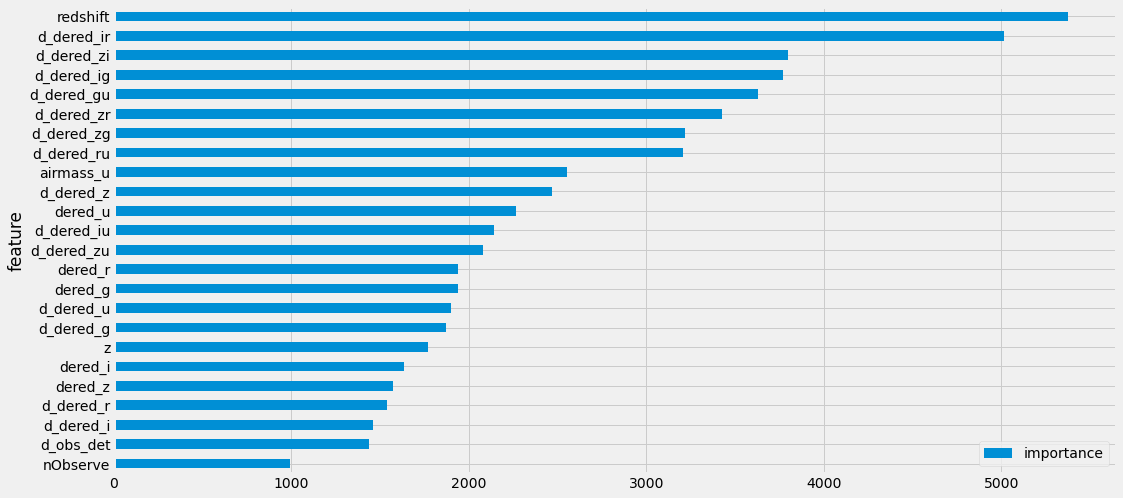

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    40737
0    29976
1     9287
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)